#Load Libraries

In [2]:
import numpy as np
import torch

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

import random

SEED = 595

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# ! pip install transformers
# ! pip install datasets
# ! pip install evaluate
# !pip install pytorch_lightning
# !pip install sentencepiece

from transformers import pipeline, T5ForConditionalGeneration, T5Tokenizer,AutoTokenizer, BertForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import evaluate
from tqdm.auto import tqdm
import sentencepiece as spm


2023-12-05 15:00:09.616844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 15:00:09.616886: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 15:00:09.663881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 15:00:14.889792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 15:00:30.117023: W tensorflow/c

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#Data load

In [7]:
# model = T5ForConditionalGeneration.from_pretrained('t5-base')
# tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",)#T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")#T5Tokenizer.from_pretrained('t5-base')

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Regression Task

In [3]:
import torch
with open("2018-Valence-reg-En-train.txt") as f: #use utf-8 text open
  lines=f.readlines()
  # lines=txt.split('\n')
lines[0],lines[1],lines[2]

('ID\tTweet\tAffect Dimension\tIntensity Score\n',
 '2017-En-30153\t@liamch88 yeah! :) playing well \tvalence\t0.600\n',
 "2017-En-40929\tAt least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society\tvalence\t0.484\n")

In [8]:
from torch.utils.data import Dataset, DataLoader
class ImdbDataset(Dataset):
  def __init__(self, tokenizer, data_dir, type_path,  max_len=512):
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.pos_files=data_dir#

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]#["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]#["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    self._buil_examples_from_files(self.pos_files)

  def _buil_examples_from_files(self, files):
    with open(files,'r') as f: #use utf-8 text open
      lines=f.readlines()

    lines=lines[1:]
    for string in lines:
        line=string[:-2].strip().split('\t')
        line=[i for i in line if i!='']
        text=line[1]+'. '+line[2]+" "
        target=str(line[3])+" "
       
    

        # tokenize inputs
        tokenized_inputs = self.tokenizer.batch_encode_plus(
          [text], max_length=self.max_len, return_tensors="pt",pad_to_max_length=True,#padding='longest'#
        )
        # tokenize targets, line[3]
        tokenized_targets = self.tokenizer.batch_encode_plus(
          [target], max_length=3,  return_tensors="pt",pad_to_max_length=True,#padding='longest'#
        )
#         print(target,self.tokenizer.decode(tokenized_targets["input_ids"][0]))#self.tokenizer.decode(tokenized_targets["input_ids"])
        self.inputs.append(tokenized_inputs)
        self.targets.append(float(line[3]))
def get_dataset(tokenizer, type_path, args):
    if type_path=="train":
        return ImdbDataset(tokenizer=tokenizer, data_dir="2018-Valence-reg-En-train.txt", type_path=type_path,  max_len=args.max_seq_length)#
    else:
        return ImdbDataset(tokenizer=tokenizer, data_dir="2018-Valence-reg-En-dev.txt", type_path=type_path,  max_len=args.max_seq_length)


In [3]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [9]:
# val_dataset.inputs[0]['input_ids']
# import argparse
# val_dataset = get_dataset(tokenizer=tokenizer, type_path="train", args=args)
# test_dataset=get_dataset(tokenizer=tokenizer, type_path="test", args=args)
# data = val_dataset[1]
# print(val_dataset.targets[0])
import argparse
args_dict=dict(max_seq_length=40)
args = argparse.Namespace(**args_dict)
val_dataset = get_dataset(tokenizer=tokenizer, type_path="train", args=args)
test_dataset=get_dataset(tokenizer=tokenizer, type_path="test", args=args)
data = val_dataset[1]
print(tokenizer.decode(data['source_ids']))
print(val_dataset.targets[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/lmou/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


[CLS] at least i don't have a guy trying to discourage me anymore in what i want to do he will never become anything worth contributing to society. valence [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
0.6


In [40]:
print(tokenizer.decode(data['source_ids']))
print(tokenizer.decode(data['target_ids'])[:-4])

At least I don't have a guy trying to discourage me anymore in what I want to do he will never become anything worth contributing to society. valence</s> <pad> <pad> <pad> <pad>
0.48


In [5]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup,
    BertConfig
)

[nltk_data] Downloading package punkt to /home/lmou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
next(dataloader_iterator)

In [55]:
n_gpu=1
gradient_accumulation_steps=64
num_train_epochs=20
warmup_steps=0
adam_epsilon=1e-8
learning_rate=0.001
weight_decay=0.0
no_decay = ["bias", "LayerNorm.weight"]
model_self = T5ForConditionalGeneration.from_pretrained("t5-small")
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model_self.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": weight_decay,
    },
    {
        "params": [p for n, p in model_self.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]
dataloader = DataLoader(val_dataset, batch_size=32, drop_last=True, shuffle=True, num_workers=2)
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
opt = optimizer
t_total = (
    (len(dataloader.dataset) // (32 * max(1, n_gpu)))
    // gradient_accumulation_steps
    * float(num_train_epochs)
)
scheduler = get_linear_schedule_with_warmup(
    opt, num_warmup_steps=warmup_steps, num_training_steps=t_total
)
lr_scheduler = scheduler

dataloader_iterator = iter(dataloader)
for i in range(int(t_total)):
    try:
      batch=next(dataloader_iterator)
    except:
      dataloader_iterator = iter(dataloader)#'source_ids', 'source_mask', 'target_ids', 'target_mask'
      batch = next(dataloader_iterator)
    targets = batch["target_ids"]
    targets[targets[:, :] == val_dataset.tokenizer.pad_token_id] = -100
    inputs,inputs_mask= batch["source_ids"], batch["source_mask"]
    target_mask=batch["target_mask"]
    y_pred = model_self(input_ids=inputs,
        attention_mask=inputs_mask,
        labels=targets,
        decoder_attention_mask=target_mask)
    print(y_pred.loss)
    optimizer.step()
    optimizer.zero_grad()
    lr_scheduler.step()


In [42]:
from sklearn.metrics import mean_squared_error
loader = DataLoader(test_dataset, batch_size=8, drop_last=True, shuffle=True, num_workers=2)
model_self.eval()
outputs = []
targets = []
for batch in tqdm(loader):
    outs = model_self.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'],
                              max_length=35)
    print([i for i in outs])
    print(tokenizer.decode(outs[0]),tokenizer.decode(batch["target_ids"][0]))
    break

    dec = [float(tokenizer.decode(ids)[:-4]) for ids in outs]
    target = [float(tokenizer.decode(ids)[:-4]) for ids in batch["target_ids"]]

    outputs.extend(dec)
    targets.extend(target)
# mean_squared_error(outputs,targets)

  0%|          | 0/56 [00:01<?, ?it/s]

[tensor([    0,  1713, 28365,    15,   434,    23,  6992,     3,    18,     3,
          547,   277,     3, 13366,  5591,   453,    30,   271,    39,  4663,
        12644,    83,  1162,  1044,    79,    31,   195,   453,    30,   271,
         1713,    51,  4901,   179,     5]), tensor([    0, 32099,     8,     3,   210,  1795,   107,    13,     3,     9,
         1713,  6623,   109,  1907,    51,     9, 12603,     6, 17144,     6,
         1713,  6623,   109,  1907,    51,     9,    28,     3,     9,  1229,
            5,     3,     2,    27,    31]), tensor([    0,    86,   204,   727,   985,    13,     8,  1974,    47,     3,
            9,   207, 12082, 12373,  1974,    13,  1233,  1713,   188,    29,
          232,    32,   279, 17475,     9,  3320,    17,     9,     9,   102,
         2338,  1713,   134,    52,    77]), tensor([    0,  3320,    29, 10398, 20884,  2681,   455,    21,  2111,     3,
            9,  1907,  7933,     4,  1274,   977,     6,   718,  4981,     6,
      

t5-small


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[]


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[]
tensor(0.0436, device='cuda:0', grad_fn=<MeanBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

[0.043595753610134125]
tensor(0.0175, device='cuda:0', grad_fn=<MeanBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

[0.043595753610134125, 0.01749550551176071]
tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

[0.043595753610134125, 0.01749550551176071, 0.010817151516675949]
tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)


Validation: |          | 0/? [00:00<?, ?it/s]

[0.043595753610134125, 0.01749550551176071, 0.010817151516675949, 0.008255386725068092]
tensor(0.0072, device='cuda:0', grad_fn=<MeanBackward0>)


`Trainer.fit` stopped: `max_epochs=5` reached.


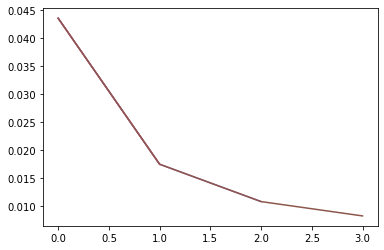

In [20]:
import matplotlib.pyplot as plt
args_dict = dict(
    data_dir="2018-Valence-reg-En-train.txt", # path for data files
    output_dir="./", # path to save the checkpoints
    model_name_or_path='t5-small',
    tokenizer_name_or_path='t5-small',
    max_seq_length=50,
    learning_rate=2e-5,
    weight_decay=0.0,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=5,
    # gradient_accumulation_steps=4,
    n_gpu=1,
    # early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)
class T5FineTuner(pl.LightningModule):
  def __init__(self, hparams):
    super(T5FineTuner, self).__init__()
    print(hparams.model_name_or_path)
    self.hparamss = hparams
    self.validation_step_outputs = []
    self.training_step_outputs= []
#     self.automatic_optimization = False ,ignore_mismatched_sizes=True

    self.model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1).cuda()#T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
    config = BertConfig.from_pretrained(
            "bert-base-uncased",#'textattack/bert-base-uncased-yelp-polarity',
            num_labels = 1,
#             output_attentions = False,
#             output_hidden_states = False,
#             hidden_dropout_prob=0.5,
#             args={
#                 'use_cached_eval_features': False,
#                 'no_cache': True,
#                 'overwrite_output_dir': True,
#                 'reprocess_input_data': True,
#             }
        )

#     self.model = BertForSequenceClassification(config)
    self.tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")#T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)

  def is_logger(self):
    return self.trainer.global_rank <= 0

  def forward(
      self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None,labels=None
  ):
    return self.model(
        input_ids,
        attention_mask=attention_mask,
#         decoder_input_ids=decoder_input_ids,
#         decoder_attention_mask=decoder_attention_mask,
        token_type_ids=None, 
        labels=labels,
    )

  def _step(self, batch):
    lm_labels = batch["target_ids"]
    lm_labels=lm_labels.type(torch.float32)#.to(device)
#     lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

    outputs = self(
        input_ids=batch["source_ids"],
        attention_mask=batch["source_mask"],
        labels=lm_labels,
#         decoder_attention_mask=batch['target_mask']
    )
    
    
    loss = outputs[0]
#     print(lm_labels,outputs)
    self.validation_step_outputs.append(loss)

    return loss

  def training_step(self, batch, batch_idx):
#     print(batch)
    loss = self._step(batch)
#     self.lr_scheduler.step()
#     print("train loss",loss)
    self.training_step_outputs.append(loss)

    tensorboard_logs = {"train_loss": loss}
    return {"loss": loss, "log": tensorboard_logs}

  def on_train_epoch_end(self):#, outputs
    avg_train_loss = torch.stack(self.validation_step_outputs).mean()
#     print(avg_train_loss)
    # avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
    tensorboard_logs = {"avg_train_loss": avg_train_loss}

    return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def validation_step(self, batch, batch_idx):
    loss = self._step(batch)
#     print("val loss ",loss)
    self.validation_step_outputs.append(loss)
    return {"val_loss": loss}

  def on_validation_epoch_end(self):#, outputs
    avg_loss = torch.stack(self.validation_step_outputs).mean()
#     avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    tensorboard_logs = {"val_loss": avg_loss}

    # self.log("validation_epoch_average", avg_loss)
#     self.validation_step_outputs.clear()  # free memory
#     self.validation_step_outputs=[]

    return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

  def configure_optimizers(self):
    "Prepare optimizer and schedule (linear warmup and decay)"

    model = self.model
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": self.hparamss.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,
        },
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparamss.learning_rate, eps=self.hparamss.adam_epsilon)
    self.opt = optimizer
    return [optimizer]

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        optimizer.step()
        self.lr_scheduler.step()
  # def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None):
  #   # if self.trainer.use_tpu:
  #   #   xm.optimizer_step(optimizer)
  #   # else:
  #   optimizer.step()
  #   optimizer.zero_grad()
  #   self.lr_scheduler.step()

  def get_tqdm_dict(self):
    tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

    return tqdm_dict

  def train_dataloader(self):
    train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", args=self.hparamss)
    dataloader = DataLoader(train_dataset, batch_size=self.hparamss.train_batch_size, drop_last=True, shuffle=True, num_workers=2)
    t_total = (
        (len(dataloader.dataset) // (self.hparamss.train_batch_size * max(1, self.hparamss.n_gpu)))
        # // self.hparamss.gradient_accumulation_steps
        * float(self.hparamss.num_train_epochs)
    )
    scheduler = get_linear_schedule_with_warmup(
        self.opt, num_warmup_steps=self.hparamss.warmup_steps, num_training_steps=t_total
    )
    self.lr_scheduler = scheduler
    return dataloader

  def val_dataloader(self):
    val_dataset = get_dataset(tokenizer=self.tokenizer, type_path="val", args=self.hparamss)
    return DataLoader(val_dataset, batch_size=self.hparamss.eval_batch_size, num_workers=2)
logger = logging.getLogger(__name__)

class LoggingCallback(pl.Callback):
  def __init__(self):
        self.collection = []

  def on_train_epoch_end(self, trainer, pl_module):
        # do something with all training_step outputs, for example:
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        print(epoch_mean)
        self.collection.append(epoch_mean.detach().cpu().item())
        pl_module.log("training_epoch_mean", epoch_mean)
        # free up the memory
        pl_module.training_step_outputs.clear()
  def on_validation_end(self, trainer, pl_module):
    logger.info("***** Validation results *****")
    if pl_module.is_logger():
      metrics = trainer.callback_metrics
      # Log results
      for key in sorted(metrics):
        if key not in ["log", "progress_bar"]:
          logger.info("{} = {}\n".format(key, str(metrics[key])))
    plt.plot(range(len(self.collection)),self.collection)
    print(self.collection)
    plt.savefig('bert.png')

  def on_test_end(self, trainer, pl_module):
    logger.info("***** Test results *****")

    if pl_module.is_logger():
      metrics = trainer.callback_metrics

      # Log and save results to file
      output_test_results_file = os.path.join(pl_module.hparamss.output_dir, "test_results.txt")
      with open(output_test_results_file, "w") as writer:
        for key in sorted(metrics):
          if key not in ["log", "progress_bar"]:
            logger.info("{} = {}\n".format(key, str(metrics[key])))
            writer.write("{} = {}\n".format(key, str(metrics[key])))
    
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
     dirpath=args.output_dir,monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    # accumulate_grad_batches=args.gradient_accumulation_steps,
    # gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    # early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    # amp_level=args.opt_level,
    # gradient_clip_val=args.max_grad_norm,
    # checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)
model = T5FineTuner(args)
trainer = pl.Trainer(**train_params)
trainer.fit(model)

In [23]:
from sklearn.metrics import mean_squared_error
loader = DataLoader(test_dataset, batch_size=32, drop_last=True, shuffle=True, num_workers=2)
def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
#     outs = model.model.generate(input_ids=batch['source_ids'], 
#                               attention_mask=batch['source_mask'],
#                               max_length=args.max_seq_length)
    with torch.no_grad():      
        outs = model(input_ids=batch['source_ids'], 
                                  attention_mask=batch['source_mask'],
                                  )
#         print(outs)
        dec=outs.logits.squeeze().tolist()
        #.detach().cpu().to_list()
        target=batch['target_ids'].tolist()
#     break
#         print(target)

#     for i in range(len(outs)):
#         ids=batch["target_ids"][i]
# #         print(tokenizer.decode(ids),tokenizer.decode(ids)[:-4])
# #         break
#         if is_float(tokenizer.decode(ids)[:-4]):
#             target.append(float(tokenizer.decode(ids)[:-4]))
#         else:
#             continue
#         ids=outs[i]
#         splitted=tokenizer.decode(ids).split()
#         for s in splitted:
#             if s !="<pad>":
#                 if is_float(s):
#                     dec.append(float(s))
#                 elif is_float(s[:-4]):
#                     dec.append(float(s[:-4]))
#                 else:
#                     dec.append(0.5)

    outputs.extend(dec)
    targets.extend(target)
mean_squared_error(outputs,targets)

  0%|          | 0/14 [00:00<?, ?it/s]

0.017070663288027876

In [24]:
X=[]
for batch in tqdm(loader):
    print(batch['source_ids'].shape)
    X.append(batch['source_ids'])
X=torch.stack(X).reshape(-1,45)

  0%|          | 0/14 [00:00<?, ?it/s]

torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])
torch.Size([32, 45])


In [25]:
from scipy.stats import pearsonr 
# print(X[0])
pearsonr(outputs,targets)

(0.8154554644343006, 5.747724948880483e-108)

In [24]:
outputs[1:10],targets[1:10],len(set(targets)),len(outputs),len(targets)

([0.3230552077293396,
  0.2604173421859741,
  0.4456808865070343,
  0.23358213901519775,
  0.5484130382537842,
  0.724588930606842,
  0.6375454068183899,
  0.6982479095458984,
  0.4598047435283661],
 [0.33, 0.31, 0.38, 0.1, 0.64, 0.48, 0.68, 0.86, 0.33],
 89,
 448,
 448)

In [10]:
outputs[1:10],targets[1:10],len(set(targets)),len(outputs),len(targets)

([0.46, 0.24, 0.26, 0.64, 0.66, 0.53, 0.08, 0.32, 0.72],
 [0.66, 0.11, 0.52, 0.63, 0.64, 0.87, 0.27, 0.22, 0.78],
 89,
 448,
 448)

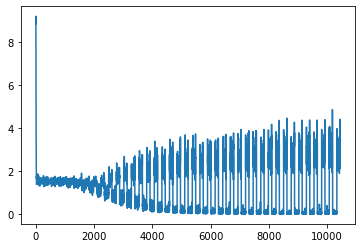

In [23]:
import  matplotlib.pyplot as plt
vali_loss=[i.tolist() for i in model.validation_step_outputs]#validation
plt.plot(range(len(vali_loss)),vali_loss)
plt.show()

In [59]:
outputs[1:10],targets[1:10],len(set(targets)),len(outputs),len(targets)

([0.5, 0.46, 0.36, 0.5, 0.48, 0.5, 0.5, 0.5, 0.51],
 [0.48, 0.31, 0.2, 0.2, 0.26, 0.13, 0.87, 0.5, 0.35],
 89,
 448,
 448)

In [14]:
torch.save(model.model.state_dict(), "./40_epoch_model")